## _Evaluation Metrics_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import torchmetrics
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# append parent dir
sys.path.append('..')

In [7]:
from src.metric_utils import compute_metrics, plot_metrics, plot_outputs_roc, plot_model_output

### _Load Data_

In [8]:
# load scores and truths from .npy files
dnn_scores = np.load("dnn_scores.npy")
dnn_truths = np.load("dnn_truths.npy")

### _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot


Use `tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()` to directly access TN, FP, FN and TP using Scikit-learn.

In [9]:
scores, truths = gnn_scores, gnn_truths

In [10]:
metrics = compute_metrics(scores,truths,threshold=0.5)

In [11]:
# Curves
# metrics.prc_precision, metrics.prc_recall, metrics.prc_thresh
# metrics.roc_tpr, metrics.roc_fpr, metrics.roc_thresh

In [12]:
metrics.accuracy

0.9904632080034684

In [13]:
metrics.recall

0.9865134872330464

In [14]:
metrics.precision

0.9701350555925851

In [15]:
metrics.f1

0.9782557223052142

### _(a) - Plot Metrics_

In [16]:
# plot_metrics(scores,truths, metrics, name="gnn")

In [17]:
# plot_outputs_roc(scores,truths, metrics, name="gnn")

In [18]:
# plot_model_output(scores, truths, name="gnn")

### _(b) - S/B Suppression_

Background rejection rate (1/FPR) is given as $1/\epsilon_{bkg}$ where $\epsilon_{bkg}$ is the fraction of fake edges that pass the classification requirement. Signal efficiency (TPR ~ Recall) ($\epsilon_{sig}$) is defined as the number of true edges above a given classification score cut over the total number of true edges. What we have?

- Signal Efficiency = $\epsilon_{sig}$ = TPR ~ Recall 
- Background Rejection = $1 - \epsilon_{bkg}$ ???
- Background Rejection Rate = $1/\epsilon_{bkg}$ = 1/FPR


First apply a edge score cut to binarized the `scores`, we will call it `preds`. The count number of false or true edges that pass this cut. Then calculated background rejection rate and signal efficiency. For making a plot one can do calculations in batch by batch mode on the test dataset.

In [19]:
import sklearn.metrics

In [21]:
# accuracy = sklearn.metrics.accuracy_score(truths, scores)    
# precision = sklearn.metrics.precision_score(y_true, y_pred)
# recall = sklearn.metrics.recall_score(y_true, y_pred)
# precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(truths, scores, average='binary')

In [22]:
# PRC Curve
prc_precision, prc_recall, prc_thresh = sklearn.metrics.precision_recall_curve(truths, scores)

In [23]:
# ROC Curve
roc_fpr, roc_tpr, roc_thresh = sklearn.metrics.roc_curve(truths, scores)
roc_auc = sklearn.metrics.auc(roc_fpr, roc_tpr)

In [24]:
# Signal, Background Rejection
sig = roc_tpr
bkg_rejection = 1/roc_fpr

/tmp/ipykernel_1602824/1842825246.py:3: RuntimeWarning: divide by zero encountered in true_divide
  bkg_rejection = 1/roc_fpr


In [25]:
# cut off eff < 0.2 or 0.5
sig_mask = sig > 0.6

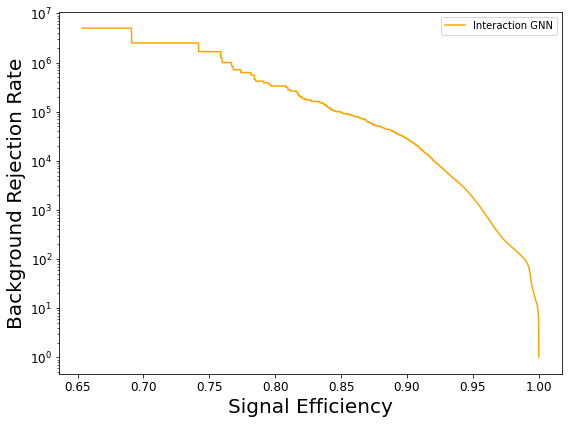

In [26]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

ax.plot(sig[sig_mask], bkg_rejection[sig_mask], label="Interaction GNN", color="orange")

# Axes Params
ax.set_xlabel("Signal Efficiency", fontsize=20)
ax.set_ylabel("Background Rejection Rate", fontsize=20)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.grid(False)
ax.legend()

# Figure Params
fig.tight_layout()
fig.savefig("gnn_SB.pdf")

### _TorchMetrics_

In [ ]:
import torchmetrics
print(torchmetrics.__version__)

In [ ]:
scores1 = np.concatenate(scores)
truths1 = np.concatenate(truths)

In [ ]:
# apply a cut
preds1 = scores1 >= 0.5

In [ ]:
true_preds1 = (preds1 == truths1).sum()
false_preds1 = (preds1 == ~truths1).sum()
num_preds1 = truths1.shape[0]

In [ ]:
# Accuracy/Classification
acc = true_preds1 / num_preds1
print(f"Classification Accuracy: {100.0*acc:4.2f}%")

In [ ]:
# Missclassification Rate = 1 - Accuracy
mis = false_preds1/num_preds1
print(f"Misclassification Rate: {100.0*mis:4.2f}%")

In [ ]:
scores = torch.cat(scores)
truths = torch.cat(truths)

In [ ]:
# apply a cut
preds = scores >= 0.5

In [ ]:
# TorchMetrics: Accuracy
from torchmetrics import Accuracy
acc = Accuracy()
acc(preds, truths)

In [ ]:
# TorchMetrics: F1Score
from torchmetrics import F1Score
f1 = F1Score()
f1(preds, truths)

In [ ]:
# TorchMetrics: CM
from torchmetrics import ConfusionMatrix
cm = ConfusionMatrix(num_classes=2)
cm(preds, truths)

In [ ]:
# TorchMetrics: AUC
from torchmetrics import AUC, AUROC
auc = AUC(reorder=True)
auc(preds.int(), truths.int())